<a href="https://colab.research.google.com/github/tkmaroon/use-cases-of-bert/blob/master/conditional_bert_contextual_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional BERT Contextual Augmentation
## Overview
This notebook performs lexical substitution using  BERT of Hugging face.
It shows how to constrain substitution candidates following the *Conditional BERT Contextual Augmentation*.



## Settings

In [2]:
#@title Setup environment
!pip install --quiet pytorch-transformers
!pip install --quiet pytorch-nlp
!pip install --quiet tqdm

     |████████████████████████████████| 184kB 10.3MB/s 
     |████████████████████████████████| 1.0MB 54.1MB/s 
     |████████████████████████████████| 870kB 77.6MB/s 
     |████████████████████████████████| 92kB 6.8MB/s 


In [0]:
#@title Setup common imports
import random
import math
from collections import OrderedDict
from tqdm import tqdm

import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

from torchnlp.datasets import smt_dataset

from pytorch_transformers import (
    BertConfig,
    BertTokenizer,
    BertForMaskedLM,
    BertForTokenClassification,
    AdamW,
    WarmupLinearSchedule,
)

import matplotlib.pyplot as plt
% matplotlib inline

## Examples


### Conditional BERT Contextual Augmentation


In [0]:
#@title setup common functions
class BatchIterator(object):
    def __init__(self, tokenizer, data, batchsize, device, shuffle=True, repeat=False):
        self.tokenizer = tokenizer
        self.pad_idx = self.tokenizer.convert_tokens_to_ids('[PAD]')
        self._numericalize(data)
        self.batchsize = batchsize
        self.device = device
        self.shuffle = shuffle
        self.repeat = repeat
                    
    def __len__(self):
        return math.ceil(len(self.data)/self.batchsize)

    def __iter__(self):
        while True:
            self._init_batches()
            for batch in self.batches:
                yield batch.to(self.device)
            if not self.repeat:
                return
            
    def _numericalize(self, data):
        self.data = [self.tokenizer.encode(s) for s in data]

    def _init_batches(self):
        data = random.sample(self.data, len(self.data)) if self.shuffle else self.data
        self.batches = [self._padding(data[i:i+self.batchsize]) for i in range(0, len(self.data), self.batchsize)]
    
    def _padding(self, batch):
        maxlen = max([len(b) for b in batch])
        return torch.tensor([b + [self.pad_idx for _ in range(maxlen-len(b))] for b in batch])    
    
    
class Perturbator(object):
    def __init__(self, tokenizer, vocab_range, sampling_rate=0.15, \
                 masking_ratio=0.8, replacing_ratio=0.1, unchanging_ratio=0.1):
        self.mask_idx = tokenizer.mask_token_id
        self.pad_idx = tokenizer.pad_token_id
        self.vocab_range = vocab_range
        self.sampling_rate = sampling_rate
        self.masking_ratio = masking_ratio
        self.replacing_ratio = replacing_ratio
        self.unchanging_ratio = unchanging_ratio
        assert (self.masking_ratio + self.replacing_ratio + self.unchanging_ratio) == 1.0, \
                '`masking_ratio + replacing_ratio + unchanging_ratio` must be 1.0'

    def __call__(self, batch):
        device = batch.device
        bsz, slen = batch.size()
        batch = batch.to(torch.device('cpu'))
        sampler = (torch.rand((bsz, slen)).le(self.sampling_rate)) & batch.ne(self.pad_idx) # [PAD] tokens are not sampled
        sampler[:, 0] = 0 # [CLS] tokens are not sampled
        
        masked_lm_labels = torch.where(
            sampler,
            batch,
            torch.ones_like(batch) * -100
        )

        rnd = torch.rand((bsz, slen))
        batch = torch.where(
            (self.masking_ratio >= rnd) & sampler,
            torch.ones_like(batch) * self.mask_idx,
            batch
        )
        
        th = self.replacing_ratio + self.masking_ratio
        batch = torch.where(
            ((th >= rnd) & (rnd > self.masking_ratio) & sampler), 
            torch.randint_like(batch, self.vocab_range[0], self.vocab_range[1]),
            batch,
        )
        return batch.to(device), masked_lm_labels.to(device)

In [6]:
#@title Load training data and preprocessing

train_smt = smt_dataset(train=True)

print('----- DETAILS OF TRAINING DATA -----')
print('* Data Summary')
for i in range(3):
    print(train_smt[i]['label'] + '\t' + train_smt[i]['text'][:100] + '...')
print('...')
print(f'* Train data size: {len(train_smt)}')

unique_labels = set([data['label'] for data in train_smt])
print(f'* class: {unique_labels}')

train_data = ['[' + data['label'].upper() + '] ' + data['text'] for data in train_smt]


----- DETAILS OF TRAINING DATA -----
* Data Summary
positive	The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash...
positive	The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a colum...
positive	Singer\/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply...
...
* Train data size: 8544
* class: {'negative', 'positive', 'neutral'}


In [0]:
#@title Setup tokenizer and iterator

# Set tokenizer    
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
added_special_tokens = [ '[' + label.upper() + ']' for label in iter(unique_labels)]
tokenizer.add_tokens(added_special_tokens)

batch_size =  32#@param {type:"integer"}
assert batch_size > 0, 'Please set `batch_size` value more than zero'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iter = BatchIterator(tokenizer, train_data, batch_size, device)
#train_iter = BatchIterator(tokenizer, small_train, batch_size, device)


In [8]:
#@title Build a model
config = BertConfig.from_pretrained('bert-base-uncased', vocab_size=len(tokenizer))
model = BertForMaskedLM(config)
model.to(device)

# freeze bert
# for param in model.bert.parameters():
#    param.requires_grad = False

print('Built a model!')

Built a model!


In [10]:
#@title Fine-tuning
n_epochs = 10 #@param {type:"integer"}
assert n_epochs > 0, 'Please set `n_epochs` value more than zero'

learning_rate = 0.25 #@param
num_total_steps = n_epochs * len(train_iter)
num_warmup_steps = len(train_iter)

# optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)

vocab_range = (max(tokenizer.all_special_ids), min(tokenizer.convert_tokens_to_ids(added_special_tokens)))

sampling_rate = 0.2 #@param {type:"slider", min:0.1, max:1.0, step:0.05}
perturbator = Perturbator(tokenizer, vocab_range, sampling_rate)

loss_fn = CrossEntropyLoss(ignore_index=-100)

for epoch in range(1, n_epochs+1):  
    with tqdm(train_iter, dynamic_ncols=True) as pbar:
        train_loss = 0.0
        for batch in pbar: 
            bsz, slen = batch.size()
            srcs, masked_lm_labels = perturbator(batch)

            outputs = model(srcs)[0].view(bsz*slen, -1)
            loss = loss_fn(outputs, masked_lm_labels.view(-1))
            pbar.set_description(f'epoch {str(epoch).zfill(3)}')
            progress_state = OrderedDict(
                loss=loss.item(),
                bsz=bsz,
            )
            pbar.set_postfix(progress_state)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

            optimizer.step()
            # scheduler.step()
            

epoch 010: 100%|██████████| 267/267 [01:46<00:00,  2.32it/s, loss=6.47, bsz=32]


In [11]:
#@title Select condition
example = "The actors are fantastic ."

sentiment_label = '[NEGATIVE]' #@param ["[NEUTRAL]", "[NEGATIVE]", "[POSITIVE]"]
conditional_example = sentiment_label + example
tokenized_example = tokenizer.tokenize(conditional_example)
print(tokenized_example)


['[NEGATIVE]', 'the', 'actors', 'are', 'fantastic', '.']


In [12]:
#@title Output top10 candidates
masked_position = 4 #@param {type:"integer"}
tokenized_example[masked_position] = '[MASK]'
print(f'Input: {tokenized_example}')

input_tensor = torch.tensor([tokenizer.convert_tokens_to_ids(tokenized_example)]).to(device)
outputs = model(input_tensor)[0]

topk_score, topk_index = torch.topk(outputs[0, masked_position], 10)
topk_tokens = tokenizer.convert_ids_to_tokens(topk_index.tolist())
print(topk_tokens)

Input: ['[NEGATIVE]', 'the', 'actors', 'are', '[MASK]', '.']
[',', '-', 'the', "'", 'of', 'a', 's', 'and', 'is', 'to']


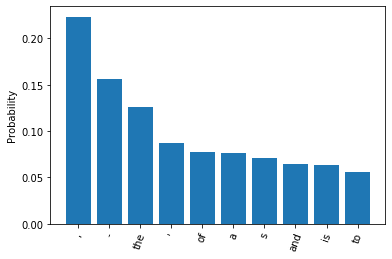

In [13]:
#@title Visualize output probabilities
plt.bar(topk_tokens, torch.softmax(topk_score, 0).tolist())
plt.xticks(rotation=70)
plt.ylabel('Probability')
plt.show()